In [108]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import json
import os
import hashlib

# Set up Generator utilities

In [2]:
def draw_pixel(color, posx, posy, grids):
    for g in grids:
        g[posy][posx] = color

def draw_filled_square(color, posx, posy, width, grids):
    for g in grids:
        max_y, max_x = g.shape        
        for y in range(posy, min(posy+width, max_y)):
            for x in range(posx, min(posx+width, max_x)):
                if x < 0 or y < 0:
                    continue
                g[y][x] = color

In [3]:
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']

def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    (h, w) = color_idx.shape if isinstance(color_idx, np.ndarray) else (len(color_idx), len(color_idx[0]))
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid

In [4]:
class ColorPicker:
    def __init__(self, random_generator, num_colors=10):
        self.rng = random_generator
        self.chosen=set()
        self.num_colors=num_colors

    def reset(self):
        self.chosen.clear()
    
    def get(self):
        if len(self.chosen) == self.num_colors:
            raise Exception("Cannot get new color. Max reached.")            
        while True:
            c = self.rng.integers(0, self.num_colors)
            if c not in self.chosen:
                break
        self.chosen.add(c)
        return c

In [5]:
TRAIN_TASK='train'
TEST_TASK='test'

INPUT='input'
OUTPUT='output'
MAX_SIZE=32

In [6]:
def plot_one(ax, grid, label, trim=True):
    ax.imshow(grid_to_rgb(grid))
    ax.set_title(label)

def plot_iopair(task, label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
    plot_one(ax1, task[INPUT], "")
    plot_one(ax2, task[OUTPUT], "")

# Generators

## Utility

In [65]:
class IdGenerator():

    def __init__(self, seed=None):
        self.src = [*'0123456789abcdef']
        self.len = 10
        self.rng = np.random.default_rng(seed)
        
    def generate(self):
        # The seed is for generating the task ID, 
        # in turn the id is used as seed to the task.
        id_arr = self.rng.choice(self.src, size=self.len).tolist()
        int_arr= []
        for x in id_arr:
            int_arr.append(int(x,16))
        # print(id_arr, int_arr)
        return ''.join(id_arr), int_arr


In [197]:
class TaskGenerator(ABC):
    
    def __init__(self, seed=None, id=None, max_grid=MAX_SIZE):
        self.id_gen = IdGenerator(seed)

        self.colors_reuse  = None
        self.colors = {}
        
        self.grid_reuse   = None
        self.grid   = {}
        
        self.points_reuse = None      
        self.points = {}   

        self.max_grid = max_grid
        self.color        = None  # Color Generator

        self.all_trains = set()
        self.all_tests  = set() 
        
    @abstractmethod        
    def generate_pair(self):
        pass        

    def set_colors_reuse(self, label): # string, set to None to generate randomly
        # 'y' is immaterial, reuse just have to be a string to take effect, 
        # but we can have multiple reusable sets key'ed different labels.        
        self.colors_reuse = label
    
    def set_grid_reuse(self, label): # string, set to None to generate randomly
        # 'y' is immaterial, reuse just have to be a string to take effect, 
        # but we can have multiple reusable sets key'ed different labels.      
        self.grid_reuse = label

    # Provide a reuse string label will allow previously created colors to be reused.
    # Handy for generating multiple task pairs
    def get_colors(self, num_colors):
        reuse = self.colors_reuse
        if reuse and reuse in self.colors:
            return self.colors[reuse]
            
        colors = [ self.color.get() for _ in range(num_colors) ]
        if reuse:
            self.colors[reuse] = colors
        return colors

    def get_grid(self, min_size=1, max_size=None, square=True):
        if not max_size:
            max_size = self.max_grid

        reuse = self.grid_reuse        
        if reuse and reuse in self.grid:
            return self.grid[reuse]
            
        if min_size == max_size:
            square = True
            gridX = min_size
        else:
            gridX = self.randInt(min_size, max_size)
        gridY = gridX if square else self.randInt(min_size, max_size) 
        grid = [ gridX, gridY ]
        
        if reuse:
            self.grid[reuse] = grid
         
        return grid

    # region=(minx, miny, maxx, maxy)
    def get_points(self, num_points, region=None):
        reuse = self.points_reuse
        if not region:
            region = (0,0,self.max_grid,self.max_grid)
        if reuse and reuse in self.points:
            return self.points[reuse]
        points = [ (self.randInt(region[0],region[2]), self.randInt(region[1],region[3])) for i in range(num_points)]
        if reuse:
            self.points[reuse] = points
        return points
        
    # Begin a new batch of pairs for a task.
    # Perform resetting activities ready for a new task.
    def begin_task(self):
        self.reset_colors()
        self.reset_grid()
        self.reset_points()
        # return a new name?

    # any clean up
    def end_task(self):
        pass

    # Clears all memory of previously chosen colors and labels.
    def reset_colors(self):
        if self.color: self.color.reset()
        self.colors.clear()
        self.colors_reuse = None        

    def reset_grid(self):
        self.grid.clear()
        self.grid_reuse   = None        

    def reset_points(self):
        self.points.clear()
        self.points_reuse = None        
        
    def randInt(self, low, high):
        return self.rng.integers(low, high)               

    def hash(self, x):
        return hashlib.sha256(repr(x).encode('utf-8')).hexdigest()
        
    def hash_pair(self, pair):
        str = json.dumps(pair, sort_keys=True)
        return self.hash(str)

    def begin_generate(self):
        task_id, seed = self.id_gen.generate()
        self.rng=np.random.default_rng(seed)
        self.color = ColorPicker(self.rng) 
        self.current_task_id = task_id
        self.current_trains = []
        self.current_tests = []
        return task_id

    def generate_clashfree_pair(self, clashset, label):
        counter = 0
        colors = None
        while True:
            pair, colors = self.generate_pair(colors=colors)
            hash = self.hash_pair(pair)
            counter += 1            
            # print("pair ", hash)
            if hash not in clashset:
                break
            else:
                # print('Clashed with '+label)
                if counter == 100:
                    raise RuntimeError("Reached 100 clashes")
        return pair, hash
    
    def generate_trains(self, num_pairs=None):
        # Choose how many train cases
        if not num_pairs:
            dice = self.randInt(0, 100)
            num_pairs = 3 
            if dice < 5:
                num_pairs = 5
            elif dice < 10:
                num_pairs = 4
            # print(num_pairs, "demos")
        # Generate all the pairs              
        for _ in range(num_pairs): 
            pair, hash = self.generate_clashfree_pair(self.all_tests, 'TestSet')
            self.current_trains.append(pair)
            # make sure those in the test cases will never appear in the train cases
            self.all_trains.add( hash )        
        return self.current_trains
            
    def generate_tests(self, num_tests=None):
        # Choose how many test cases
        if not num_tests:
            num_tests = 2 if self.randInt(0, 100) < 5 else 1
            # print(num_tests, "tests")

        for _ in range(num_tests):
            pair, hash = self.generate_clashfree_pair(self.all_trains, 'TrainSet')
            self.current_tests.append(pair)
            # make sure those in the test cases will never appear in the train cases
            self.all_tests.add( hash )                   
        return self.current_tests
        
    def end_generate(self):
        pass
                     
    # if num_tests is not specified, it will pick 1 95% of the time.
    def generate(self, num_pairs=None, num_tests=None):
        
        task_id = self.begin_generate()
        # print(task_id, num_pairs, num_tests)
        self.generate_trains(num_pairs)
        if not self.colors_reuse: self.color.reset()
        self.generate_tests(num_tests)

        data = {
            'train': self.current_trains, 
            'test': self.current_tests
        }

        self.end_generate()
        
        return task_id, data


In [163]:
# class xxx(TaskGenerator):
#    def __init__(self, seed, max_pts=6):
#        super().__init__(seed)
#        self.max_pts = max_pts
#    
#    def generate_pair(self):
#        return

# t = xxx(seed=123)

## Circle a Pixel

In [164]:
class CircleAPixel(TaskGenerator):
    
    def __init__(self, seed, max_pts=6):
        super().__init__(seed)
        self.max_pts = max_pts
        
    def generate_pair(self):

        # 'y' is immaterial, reuse just have to be a string to take effect, 
        # but we can have multiple reusable sets key'ed different labels.
        bgcolor, color1, color2 = self.get_colors(3) 

        # Grid
        gridX, gridY = self.get_grid(min_size=5, square=False) # no reuse
        in_grid = np.ones((gridY, gridX), dtype=int) * bgcolor
        ot_grid = np.ones((gridY, gridX), dtype=int) * bgcolor

        # Points
        num_points = 1 if self.max_pts == 1 else self.randInt(1,self.max_pts)
        pt_list = self.get_points(num_points, region=(0,0,gridX,gridY))

        # Generate
        for x, y in pt_list: draw_filled_square(color2, x-1, y-1, 3, [ot_grid])   
        for x, y in pt_list: draw_pixel(color1, x, y, [in_grid, ot_grid])

        # Package
        return {INPUT:in_grid.tolist(), OUTPUT:ot_grid.tolist()}


## Move a Pixel

In [198]:
class MoveAPixelX(TaskGenerator):
    
    def __init__(self, seed, id=None, max_pts=6, max_grid=MAX_SIZE):
        super().__init__(seed=seed, id=id, max_grid=max_grid)
        self.max_pts = max_pts
        
    def generate_pair(self,square=False,colors=None):

        if colors:
            bgcolor, color1 = colors
        else:
            bgcolor, color1 = self.get_colors(2) 

        # Grid
        gridX, gridY = self.get_grid(min_size=5, square=square)
        in_grid = np.ones((gridY, gridX), dtype=int) * bgcolor
        ot_grid = np.ones((gridY, gridX), dtype=int) * bgcolor

        # Points
        num_points = 1 if self.max_pts == 1 else self.randInt(1,self.max_pts)
        pt_list = self.get_points(num_points, region=(0,0,gridX-1,gridY))

        # Generate
        # for x, y in pt_list: draw_filled_square(color2, x-1, y-1, 3, [ot_grid])   
        for x, y in pt_list: draw_pixel(color1, x, y, [in_grid])
        for x, y in pt_list: draw_pixel(color1, x+1, y, [ot_grid]) # move right

        # Package
        pair = {INPUT:in_grid.tolist(), OUTPUT:ot_grid.tolist()}
        # print(pair)
        return pair, (bgcolor, color1)


# Generate

- CircleAPixel(0)
- CircleAPixel(1,1) "one"
- MoveAPixelX(1,1) "one"

## Test One

processed 0 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-28d9a06539.json
processed 100 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-133bdc0f43.json
processed 200 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-64fef4065c.json
processed 300 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-1c73f288b7.json
processed 400 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-aec9f7d7d2.json
processed 500 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-b4f163bfa9.json
processed 600 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-e963240dc6.json
processed 700 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-b2d47fe03a.json
processed 800 data/core_knowledge/moveapixelxone-5x5-multicolor/moveapixelxone-5x5-multicolor-08641191ee.json
processed 90

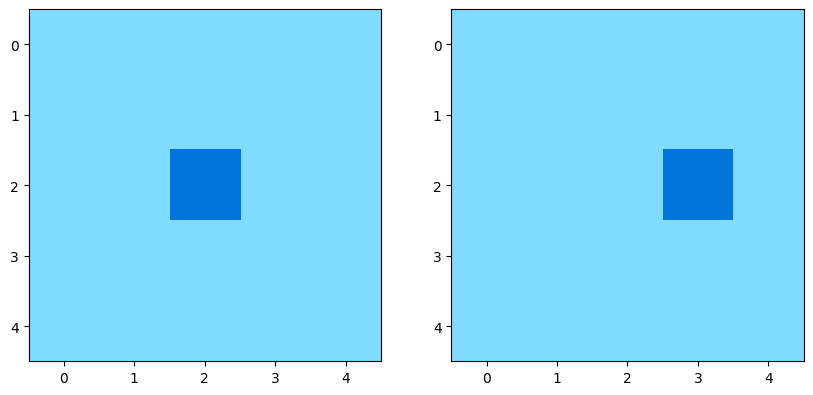

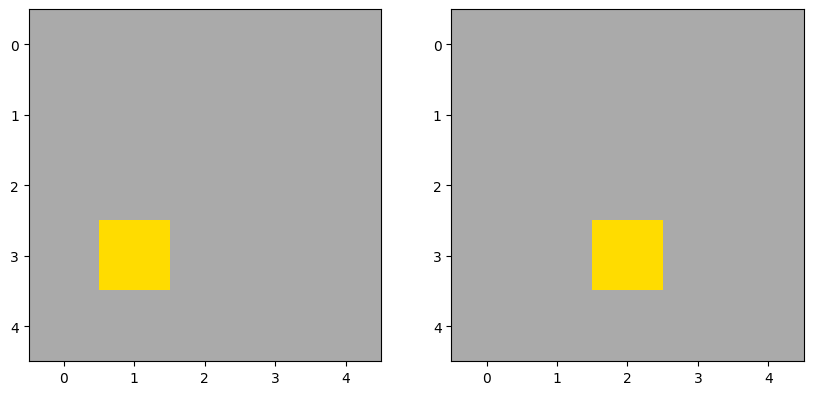

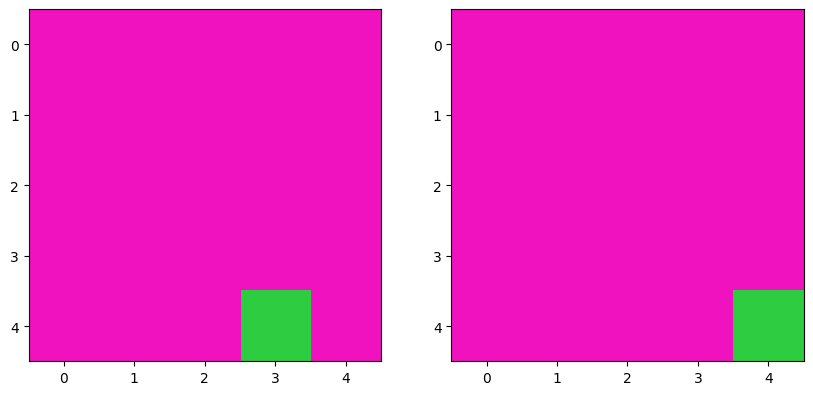

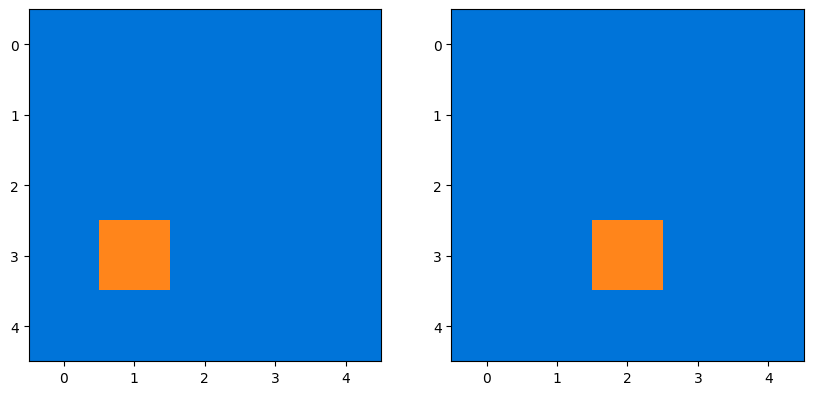

In [199]:
# For each task we create 4-5 pairs.
# Then package them up as 1 or 2 'test' task, with 2-3 'train' task.
# seed = 1 for original variable grid MoveAPixelX 1000 tasks
# task = CircleAPixel(seed,1)
modifier='one-5x5-multicolor'
seed = abs(hash(modifier)) % (10 ** 8) # 2
task = MoveAPixelX(seed, max_pts=1,max_grid=5)
task_class=task.__class__.__name__.lower()+modifier
data_dir='data/core_knowledge/'+task_class+'/'
if not os.path.exists(data_dir):
   os.makedirs(data_dir)

num_tasks = 1000
for t in range(num_tasks):
    task.begin_task() # can be reset per task
    # task.set_colors_reuse('y')
    # task.set_grid_reuse('y')
    task_id, data = task.generate()
    if t == num_tasks-1: 
        for i in range(len(data['train'])): plot_iopair(data['train'][i], "") 
        for i in range(len(data['test'])): plot_iopair(data['test'][i], "") 
    # Saves this into a json file.
    task_file = data_dir + task_class + '-' + task_id + '.json' 
    if t % int(num_tasks / min(10, num_tasks)) == 0: print("processed",t,task_file)    
    with open(task_file, 'w') as f:
        json.dump(data, f)
    task.end_task()